# Data Pre-proccesing Step

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../model_evaluation')

path = '../../codon-usage-data-set/'
df = pd.read_csv(path + 'codon_usage.csv', low_memory = False)

# removing missing value -----------------------
df = df[pd.to_numeric(df['UUU'], errors='coerce').notnull()]
df = df[pd.to_numeric(df['UUC'], errors='coerce').notnull()]

df.UUU = df.UUU.astype('float64')
df.UUC = df.UUC.astype('float64')
# ----------------------------------------------

# avoid any DNA types specified by the integers greater than 2
df = df[df.DNAtype <= 2]

# Remove plm kingdom
df = df[df.Kingdom != 'plm']

# Convert the type of target attributes to categorical (as opposed to 'str' or 'int') 
df.Kingdom = df.Kingdom.astype('category')
df.DNAtype = df.DNAtype.astype('category')

# Discard the genome entries with Ncodons less than 1000
df = df[df.Ncodons > 1000]

# Replace 'xxx' (where ‘xxx’ is one of ‘pln’, ‘inv’, ‘vrt’, ‘mam’, ‘rod’, or ‘pri’) by 'euk'
df['Kingdom'] = df['Kingdom'].replace(
                      {'pln' : 'euk' ,
                       'inv' : 'euk' ,
                       'vrt' : 'euk' ,
                       'mam' : 'euk' ,
                       'rod' : 'euk' ,
                       'pri' : 'euk' 
                      })

df = df.reset_index(drop=True)
df.head()

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,vrl,0,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,vrl,0,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,vrl,0,100755,4862,Sweet potato leaf curl virus,0.01974,0.02180,0.01357,0.01543,0.00782,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,vrl,0,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,vrl,0,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131


## Kingdom Class Distribution

In [3]:
df.groupby('Kingdom').size()

Kingdom
arc     126
bct    2916
phg     220
euk    6859
vrl    2831
dtype: int64

## DNAtype Class Distribution

In [4]:
df.groupby('DNAtype').size()

DNAtype
0    9244
1    2899
2     809
dtype: int64

### Tuning the Decision Tree Model with hyper-parameters `max_leaf_nodes`, `criterion`

In [5]:
# Tuning the hyper-parameter (max_leaf_nodes of the decision_tree_classifier)
from dt_training import tree_training
from KFold import KFold

class_vars_kingdom = pd.Series(['arc', 'bct', 'phg', 'euk', 'vrl'], dtype='category')
class_vars_dnatype = pd.Series([0, 1, 2], dtype = 'category')
codon_columns = [c for c in df.columns if c not in ['Kingdom', 'DNAtype', 'SpeciesID', 'Ncodons', 'SpeciesName']]

kfold = KFold(5, shuffle = True, random_state = 1)
df_split = kfold.split(df) 

### Model Tuning For Kingdom Classification

In [6]:
# Performing 5-fold cross-validation for Kingdom Classification
acc_train_kingdom_gini = np.zeros((19,), dtype='float32')
acc_test_kingdom_gini = np.zeros((19,), dtype='float32')
max_leaf_nodes = np.linspace(2, 20, 19, dtype='int32')

# Using gini-index as splitting criterion
for i in range(2, 21):
    tot_train = 0
    tot_test = 0
    for idx_train, idx_test in df_split:
        X_train = df.loc[idx_train, codon_columns]
        y_train = df.loc[idx_train, 'Kingdom']

        X_test = df.loc[idx_test, codon_columns]
        y_test = df.loc[idx_test, 'Kingdom']

        train, test = tree_training(class_vars_kingdom, X_train, y_train, X_test, y_test, i, 'gini')
        tot_train += train
        tot_test += test
    acc_train_kingdom_gini[i-2] = tot_train / 5
    acc_test_kingdom_gini[i-2] = tot_test / 5

# Using entropy as splitting criterion
acc_train_kingdom_entropy = np.zeros((19,), dtype='float32')
acc_test_kingdom_entropy = np.zeros((19,), dtype='float32')
for i in range(2, 21):
    tot_train = 0
    tot_test = 0
    for idx_train, idx_test in df_split:
        X_train = df.loc[idx_train, codon_columns]
        y_train = df.loc[idx_train, 'Kingdom']

        X_test = df.loc[idx_test, codon_columns]
        y_test = df.loc[idx_test, 'Kingdom']

        train, test = tree_training(class_vars_kingdom, X_train, y_train, X_test, y_test, i, 'entropy')
        tot_train += train
        tot_test += test
    acc_train_kingdom_entropy[i-2] = tot_train / 5
    acc_test_kingdom_entropy[i-2] = tot_test / 5

### Model Tuning For DNAtype Classification

In [7]:
# Performing 5-fold cross-validation for DNAtype Classification
acc_train_dnatype_gini = np.zeros((19,), dtype='float32')
acc_test_dnatype_gini = np.zeros((19,), dtype='float32')

for i in range(2, 21):
    tot_train = 0
    tot_test = 0
    for idx_train, idx_test in df_split:
        X_train = df.loc[idx_train, codon_columns]
        y_train = df.loc[idx_train, 'DNAtype']

        X_test = df.loc[idx_test, codon_columns]
        y_test = df.loc[idx_test, 'DNAtype']

        train, test = tree_training(class_vars_dnatype, X_train, y_train, X_test, y_test, i, 'gini')
        tot_train += train
        tot_test += test
    acc_train_dnatype_gini[i-2] = tot_train / 5
    acc_test_dnatype_gini[i-2] = tot_test / 5

acc_train_dnatype_entropy = np.zeros((19,), dtype='float32')
acc_test_dnatype_entropy = np.zeros((19,), dtype='float32')

for i in range(2, 21):
    tot_train = 0
    tot_test = 0
    for idx_train, idx_test in df_split:
        X_train = df.loc[idx_train, codon_columns]
        y_train = df.loc[idx_train, 'DNAtype']

        X_test = df.loc[idx_test, codon_columns]
        y_test = df.loc[idx_test, 'DNAtype']

        train, test = tree_training(class_vars_dnatype, X_train, y_train, X_test, y_test, i, 'entropy')
        tot_train += train
        tot_test += test
    acc_train_dnatype_entropy[i-2] = tot_train / 5
    acc_test_dnatype_entropy[i-2] = tot_test / 5

### Draw the accuracy vs max_leaf_nodes plot

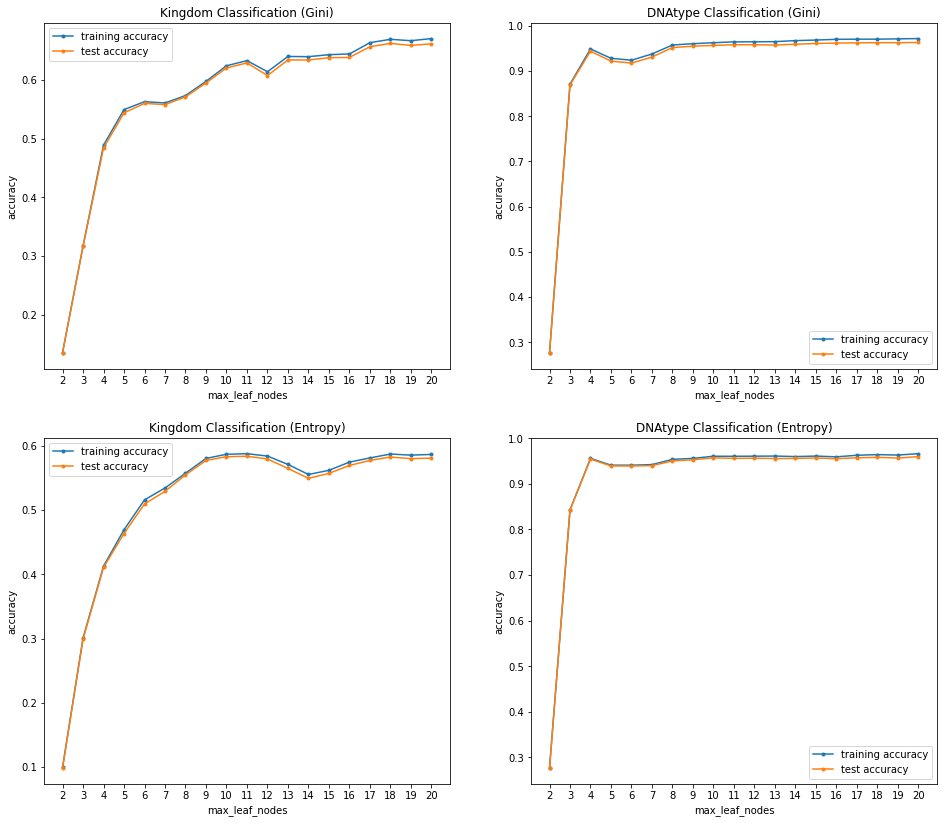

In [8]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16,14))
ax1.set_title('Kingdom Classification (Gini)')
ax1.set_xlabel('max_leaf_nodes')
ax1.set_ylabel('accuracy')
ax1.set_xticks(max_leaf_nodes)

ax1.plot(max_leaf_nodes, acc_train_kingdom_gini, marker='.', label= 'training accuracy')
ax1.plot(max_leaf_nodes, acc_test_kingdom_gini, marker='.', label= 'test accuracy')
ax1.legend()

ax3.set_title('Kingdom Classification (Entropy)')
ax3.set_xlabel('max_leaf_nodes')
ax3.set_ylabel('accuracy')
ax3.set_xticks(max_leaf_nodes)

ax3.plot(max_leaf_nodes, acc_train_kingdom_entropy, marker='.', label= 'training accuracy')
ax3.plot(max_leaf_nodes, acc_test_kingdom_entropy, marker='.', label= 'test accuracy')
ax3.legend()

ax2.set_title('DNAtype Classification (Gini)')
ax2.set_xlabel('max_leaf_nodes')
ax2.set_ylabel('accuracy')
ax2.set_xticks(max_leaf_nodes)    

ax2.plot(max_leaf_nodes, acc_train_dnatype_gini, marker='.', label= 'training accuracy')
ax2.plot(max_leaf_nodes, acc_test_dnatype_gini, marker='.', label= 'test accuracy')
ax2.legend()


ax4.set_title('DNAtype Classification (Entropy)')
ax4.set_xlabel('max_leaf_nodes')
ax4.set_ylabel('accuracy')
ax4.set_xticks(max_leaf_nodes)    

ax4.plot(max_leaf_nodes, acc_train_dnatype_entropy, marker='.', label= 'training accuracy')
ax4.plot(max_leaf_nodes, acc_test_dnatype_entropy, marker='.', label= 'test accuracy')
ax4.legend()

plt.show()

We'll use **Occam's Razor Principle** (prefer simpler models over the complex ones) to select our classification model
</br>
From the above outcomes we observe the following:
</br>
</br>
**Kingdom Classification**
</br>
best performance (with minimum number of leaf nodes) is for **11 nodes, Gini-Index as splitting criterion** 
</br>
`max_leaf_nodes:11 ,training-accuracy:0.633, test-accuracy:0.629`
</br>
</br>
**DNAtype Classification**
</br>
best performance (with minimum number of leaf nodes) is for **4 nodes, Entropy as splitting criterion**
</br>
`max_leaf_nodes:4, training-accuracy:0.956, test-accuracy:0.954`

In [9]:
print(f'max_leaf_nodes:{max_leaf_nodes[9]}, training-accuracy:{acc_train_kingdom_gini[9]:.3f}, test-accuracy:{acc_test_kingdom_gini[9]:.3f}')
print(f'max_leaf_nodes:{max_leaf_nodes[2]}, training-accuracy:{acc_train_dnatype_entropy[2]:.3f}, test-accuracy:{acc_test_dnatype_entropy[2]:.3f}')

max_leaf_nodes:11, training-accuracy:0.633, test-accuracy:0.629
max_leaf_nodes:4, training-accuracy:0.956, test-accuracy:0.954


### Build the respective optimal models

In [11]:
from sklearn.tree import DecisionTreeClassifier

X = df.loc[:,codon_columns]
y_kingdom = df['Kingdom']
y_dnatype = df['DNAtype']
# Optimal Model for Kingdom classification
model_tree_kingdom = DecisionTreeClassifier(max_leaf_nodes = 11, class_weight = 'balanced', criterion='gini')
model_tree_kingdom.fit(X, y_kingdom)

DecisionTreeClassifier(class_weight='balanced', max_leaf_nodes=11)

In [12]:
# Optimal Model for DNAtype Classification
model_tree_dnatype = DecisionTreeClassifier(max_leaf_nodes = 4, class_weight = 'balanced', criterion='entropy')
model_tree_dnatype.fit(X, y_dnatype)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_leaf_nodes=4)

### Apply the models on the data-set and draw their ROC curves (i.e. FPR vs TPR curve) to check their class-wise performance 

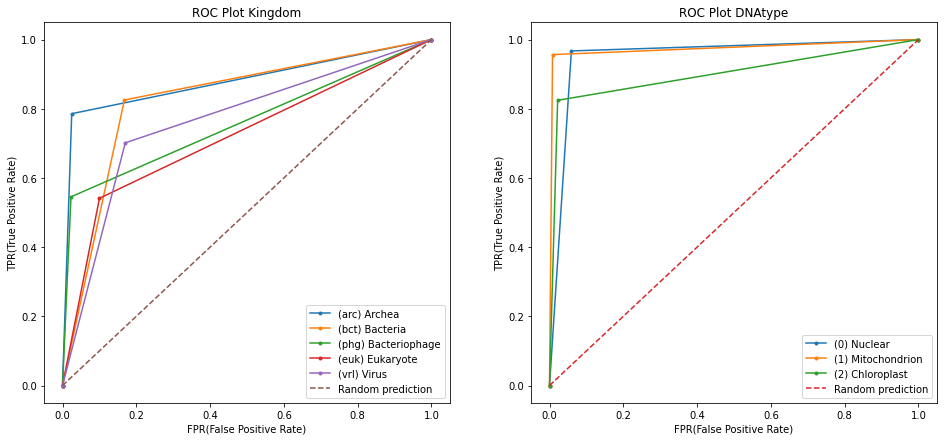

In [13]:
from sklearn.metrics import roc_curve

# Kingdom Classification ROC Plot ----------------------------------

n = len(y_kingdom)
m = len(class_vars_kingdom)

# Run the model on the data-set
y_pred_kingdom = model_tree_kingdom.predict(X)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,7))

ax1.set_title('ROC Plot Kingdom')

ax1.set_xlabel('FPR(False Positive Rate)')
ax1.set_ylabel('TPR(True Positive Rate)')

_y = np.ones((n,),dtype="int8")
_y_pred = np.ones((n,),dtype="int8")
first = True
for i in range(m):
    if not first:
        _y = np.ones((n,),dtype="int8")
        _y_pred = np.ones((n,),dtype="int8")
    class_name = class_vars_kingdom[i]
    for j in range(n):
        if y_kingdom[j] != class_name:
            _y[j] = 0
        if y_pred_kingdom[j] != class_name:
            _y_pred[j] = 0
    dt_fpr, dt_tpr, _ = roc_curve(_y, _y_pred)
    match class_name:
        case 'arc':
            class_name = '(arc) Archea'
        case 'bct':
            class_name = '(bct) Bacteria'
        case 'phg':
            class_name = '(phg) Bacteriophage'
        case 'euk':
            class_name = '(euk) Eukaryote'
        case 'vrl' :
            class_name = '(vrl) Virus'
    ax1.plot(dt_fpr, dt_tpr, marker='.', label= class_name)
    first = False

random_fpr, random_tpr, _ = roc_curve(_y, np.zeros((n,), dtype='int8'))
ax1.plot(random_fpr, random_tpr, linestyle='--', label='Random prediction')
ax1.legend()

# DNAtype Classification ROC Plot ----------------------------------

m = len(class_vars_dnatype)

# Run the model on the data-set 
y_pred_dnatype = model_tree_dnatype.predict(X)

ax2.set_title('ROC Plot DNAtype')

ax2.set_xlabel('FPR(False Positive Rate)')
ax2.set_ylabel('TPR(True Positive Rate)')

_y = np.ones((n,),dtype="int8")
_y_pred = np.ones((n,),dtype="int8")
first = True
for i in range(m):
    if not first:
        _y = np.ones((n,),dtype="int8")
        _y_pred = np.ones((n,),dtype="int8")
    
    class_name = class_vars_dnatype[i]
    for j in range(n):
        if y_dnatype[j] != class_name:
            _y[j] = 0
        if y_pred_dnatype[j] != class_name:
            _y_pred[j] = 0
    dt_fpr, dt_tpr, _ = roc_curve(_y, _y_pred)
    match class_name:
        case 0:
            class_name = '(0) Nuclear'
        case 1:
            class_name = '(1) Mitochondrion'
        case 2:
            class_name = '(2) Chloroplast'
    ax2.plot(dt_fpr, dt_tpr, marker='.', label= class_name)
    first = False

ax2.plot(random_fpr, random_tpr, linestyle='--', label='Random prediction')

ax2.legend()
plt.show()

Again we make the following inferences:
</br>
</br>
**Kingdom Classification**
</br>
*Decision Tree* model's performance isn't very great as area under the ROC curve is small for every class
</br>
**DNAtype Classification**
</br>
The model works well with decent performance
</br>

### Statistical Scores of the models built 

In [14]:
# Statistical Measures
import eval_metrics

print('Kingdom Classification-------------------')
conf_matrix = eval_metrics.confusion_matrix(y_kingdom, y_pred_kingdom, class_vars_kingdom)
print('Accuracy:%.4f' %eval_metrics.accuracy(conf_matrix))
print('Precision:%.4f' %eval_metrics.precision(conf_matrix, class_vars_kingdom))
print('Recall:%.4f' %eval_metrics.recall(conf_matrix, class_vars_kingdom))

conf_matrix = eval_metrics.confusion_matrix(y_dnatype, y_pred_dnatype, class_vars_dnatype)
print('DNAtype Classification-------------------')
print('Accuracy:%.4f' %eval_metrics.accuracy(conf_matrix))
print('Precision:%.4f' %eval_metrics.precision(conf_matrix, class_vars_dnatype))
print('Recall:%.4f' %eval_metrics.recall(conf_matrix, class_vars_dnatype))

Kingdom Classification-------------------
Accuracy:0.6427
Precision:0.6427
Recall:0.6427
DNAtype Classification-------------------
Accuracy:0.9559
Precision:0.9559
Recall:0.9559
